In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib notebook
%matplotlib notebook
# %matplotlib inline
# %matplotlib qt

In [3]:
import sys

sys.path.append('/Users/Josh/Documents/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition
from GCaMP_ROI_classifier.old_stuff import util, models, training_simCLR, augmentation

## Import training data

In [4]:
import pickle

with open('/Users/Josh/Documents/Harvard/label_data/all_stat_files_20211022.pkl', 'rb') as file:
    statFiles_scraped = pickle.load(file)

In [5]:
keys_toDelete = [
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
]
for key in keys_toDelete:
    del statFiles_scraped[key]

In [6]:
sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

images_all = np.concatenate(sf_list, axis=0)

images_all.shape

(217802, 36, 36)

In [7]:
images_all_norm = (images_all / np.sum(images_all, axis=(1,2), keepdims=True)) * 255

In [8]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_all_norm, np.arange(images_all.shape[0]), test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((185131, 36, 36), (185131,)), ((32671, 36, 36), (32671,)))

<IPython.core.display.Javascript object>


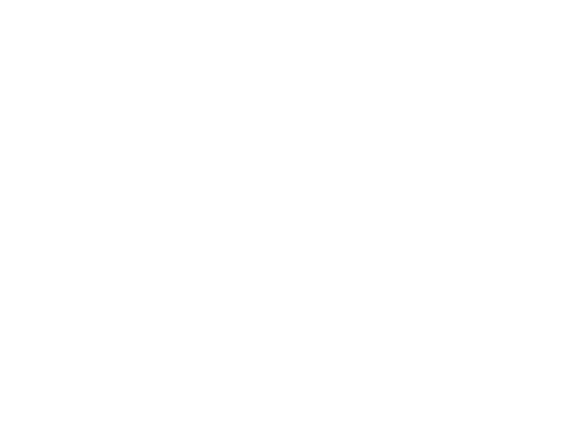

<IPython.core.display.Javascript object>


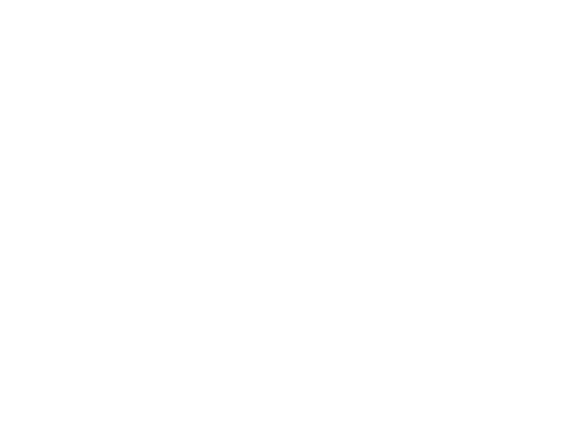

concatenated images shape: (9715, 36, 36)


<IPython.core.display.Javascript object>


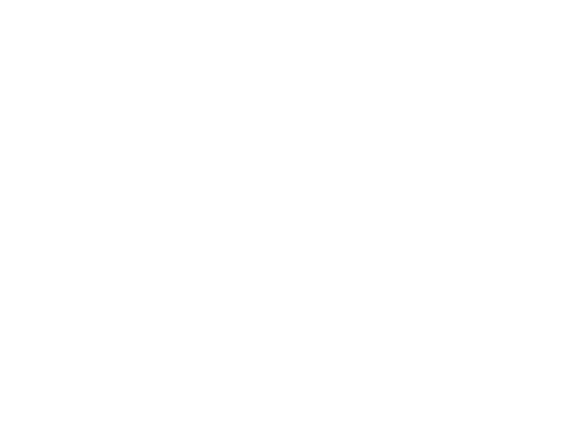

<IPython.core.display.Javascript object>


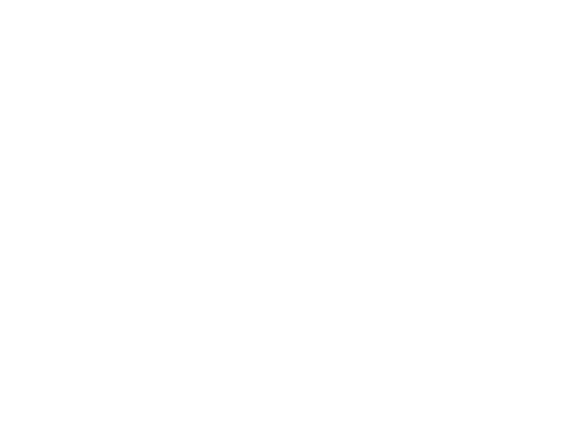

In [9]:
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [36,36],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0) *255
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

## Balance classes of inputs

In [10]:
duplicates = 1

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9715, 36, 36)
(9715,)
532
532
620
681
7881
(9715, 36, 36)
(9715,)


In [11]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_dup[:], labels_dup[:], test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((8257, 36, 36), (8257,)), ((1458, 36, 36), (1458,)))

<IPython.core.display.Javascript object>


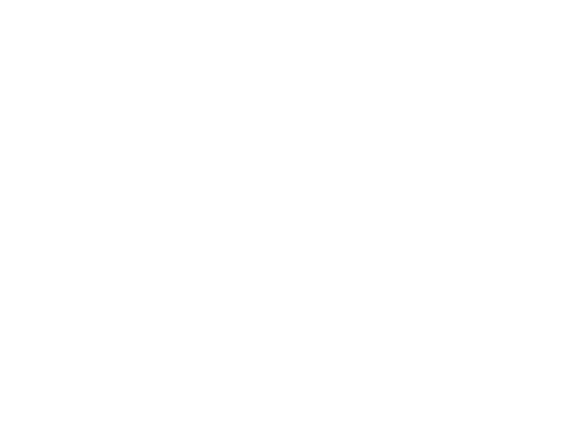

In [12]:
plt.figure()
plt.hist(labels_dup, 20);

## Define augmentation pipeline

In [21]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),
    
#     torchvision.transforms.GaussianBlur(kernel_size=5,
#                                         sigma=(0.0001, 0.5)),
    
#     torchvision.transforms.RandomPerspective(distortion_scale=0.4, 
#                                              p=0.5, 
#                                              interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                              fill=0),
#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.3, 0.3),
#                                         scale=(0.7, 1.7), 
#                                         shear=(-30, 30, -30, 30), 
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         fillcolor=None, 
#                                         resample=None),
    
#     augmentation.AddPoissonNoise(   level_bounds=(0,0.7),
#                                     prob=1),

#     augmentation.AddGaussianNoise(  mean=0, 
#                                     std=0.4,
#                                     prob=1),
)
# scripted_transforms = torch.jit.script(transforms)
scripted_transforms = transforms



dataset_train = util.dataset_simCLR(torch.tensor(X_train), 
                                    y_train, 
                                    n_transforms=2, 
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64 )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=1024,
            #                                     sampler=sampler,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=False,
#                                                 num_workers=32,
                                                num_workers=0,
#                                                 num_workers=16,
#                                                 prefetch_factor=3,
#                                                 persistent_workers=True,
                                                )

# dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
#                                     y_val, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_val = torch.utils.data.DataLoader(   dataset_val,
#                                                 batch_size=128,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
#                                                 )         

0.00018596649169921875


<IPython.core.display.Javascript object>


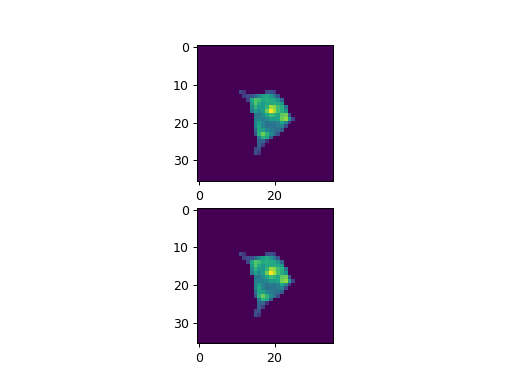

0.0386350154876709


<IPython.core.display.Javascript object>


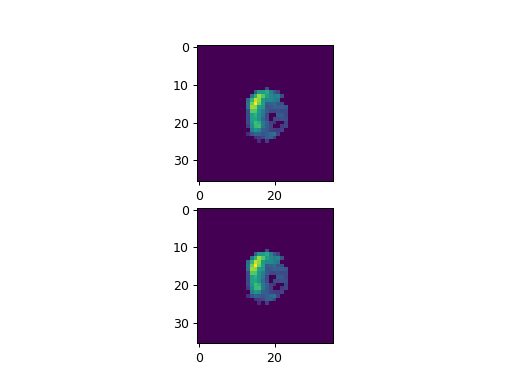

0.03654766082763672


<IPython.core.display.Javascript object>


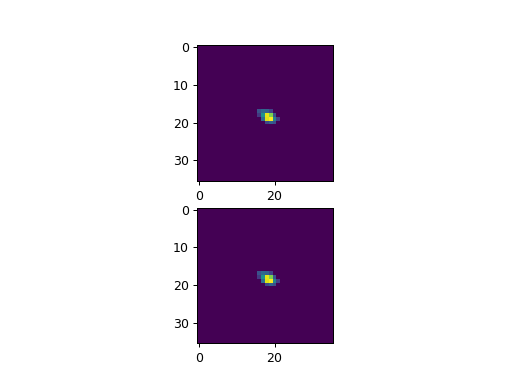

0.03518795967102051


<IPython.core.display.Javascript object>


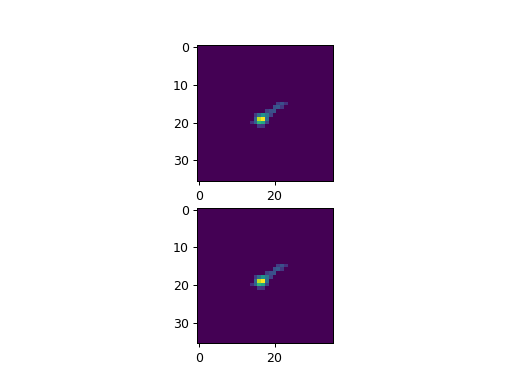

In [22]:
import time

%matplotlib notebook
tic=time.time()
for ii, im in enumerate(dataset_train):
#     for jj in range(im[0])
    print(time.time() - tic)
    tic = time.time()
#     print((im[0][0]).shape)
    fig, axs = plt.subplots(len(im[0]))
    for jj, ax in enumerate(axs):
        ax.imshow(im[0][jj].cpu().squeeze())
    if ii > 2:
        break

## Train

In [14]:
DEVICE = torch_helpers.set_device(use_GPU=True)

no GPU available. Using CPU.


In [75]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=128)
model.train()
# criterion = CrossEntropyLoss()
criterion = CrossEntropyLoss(reduction='none')

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0005,
#                                                    gamma=1,
                                                  )
val_obj = training_simCLR.validation_Obj(   X_val,
                                            y_val,
                                            model,
                                            criterion,
                                            DEVICE=DEVICE,
                                            dtype_X=torch.float32,
                                            dtype_y=torch.int64) # Needs to take in weights

model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses_train, losses_val, val_accs = [], [np.nan], []

In [76]:
sys.path.append('/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/')

In [ ]:
import numpy as np
from training_classHead import HeadModel

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# classHead = HeadModel(model, RandomForestClassifier)
classHead = HeadModel(model, LogisticRegression)
dataset_train.headmodel = classHead

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    training_simCLR.epoch_step( dataloader_train, 
                                model, 
                                optimizer, 
                                criterion, 
                                scheduler=scheduler, 
                                temperature=0.5,
                                loss_rolling_train=losses_train, 
                                device=DEVICE, 
                                do_validation=False,
                                validation_Object=val_obj,
                                loss_rolling_val=losses_val,
                                verbose=2,
                                verbose_update_period=10,
                               )
    # model predict
    # Update model in DS
    # get item calls model for each sample
    # output
    # X sample weights predictions
    
    classHead.fit(X_train[:, None, :, :], y_train)
    
    proba = classHead.predict_proba(X_train[:, None, :, :])
    class_weights = proba.sum(axis=0)
    total_num = class_weights.sum()
    
    eps = 1e-4
    
    class_weights[class_weights <= 3] = total_num
    weightings = class_weights.sum()/class_weights
    final_weights = weightings / weightings.sum()
    
    print(class_weights)

    dataset_train.set_classweights(final_weights)
    
    print('dataset_train.final_weights', dataset_train.class_weights)


epoch: 0
Iter: 0/8, loss_train: 1.249e+04, loss_val: nan, lr: 0.0009536
[ 445.74  535.1  8257.    581.69 6693.42]
dataset_train.final_weights [0.36766535 0.30626641 0.01984778 0.28173624 0.02448422]
epoch: 1
Iter: 0/8, loss_train: 971.69, loss_val: nan, lr: 0.00094979
[ 447.82  538.77 8257.    578.92 6690.7 ]
dataset_train.final_weights [0.36685127 0.30492295 0.01989625 0.28377554 0.02455398]
epoch: 2
Iter: 0/8, loss_train: 1036.0, loss_val: nan, lr: 0.000946


In [60]:
# [A, B, C]
# [a, b, b]
# [100, 50, 50]
# x = 100
# [x, x/2, x/2]
# [1, 2, 2]

# [1/5, 2/5, 2/5]


In [33]:
# import numpy as np
# from training_classHead import HeadModel

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import confusion_matrix

# import torchvision.transforms    

# transforms = torch.nn.Sequential()
# scripted_transforms = transforms


# dataset_train = util.dataset_simCLR(torch.tensor(X_train), 
#                                     y_train, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=1024,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=False,
#                                                 num_workers=0,
# #                                                 num_workers=16,
# #                                                 prefetch_factor=3,
# #                                                 persistent_workers=True,
#                                                 )


# classHead = HeadModel(model, LogisticRegression)
# dataset_train.set_headmodel(classHead)

# n_epochs=300000

# i_batch = 0
# dl = dataset_train.__getitem__(0)
# # if True:

# # for i_batch, (X_batch, y_batch, idx_batch, sample_weight) in enumerate(dataloader_train):
# for i_batch, (dl) in enumerate(dataloader_train):
# #     print(X_batch)
# #     print(y_batch)
# #     print(idx_batch)
# #     print(sample_weight)
#     print(dl)
    
#     classHead.fit(X_train[:, None, :, :], y_train)
#     dataset_train.set_headmodel(classHead)
#     preds = classHead.predict(X_train[:, None, :, :])
    
#     class_weights = np.zeros((preds.shape[0], classHead.n_classes)).astype(int)
#     class_weights[np.arange(preds.shape[0]), preds] = 1
#     class_weights = class_weights.sum(axis=0)

#     total_num = class_weights.sum()

#     class_weights[class_weights == 0] = total_num
#     class_weights[class_weights == 1] = total_num
#     weightings = class_weights.sum()/class_weights
#     final_weights = weightings / weightings.sum()

#     dataset_train.set_classweights(final_weights)
    
#     print('dataset_train.final_weights', dataset_train.class_weights)
    
    
#     sample_weight = torch.tensor([1.0], device=dataset_train.X.device)

#     if dataset_train.headmodel is not None and dataset_train.headmodel.n_classes is not None:
#         prediction = dataset_train.headmodel.predict(dataset_train.X[0:16])
#         print(prediction)
#         onehot_prediction = np.eye(dataset_train.headmodel.n_classes)[prediction]
#         print(onehot_prediction)
#         sample_weight = onehot_prediction * dataset_train.class_weights
#         print(sample_weight)
#         sample_weight = torch.tensor(sample_weight, device=dataset_train.X.device)
#         print(sample_weight)
#         sample_weight = sample_weight.sum(axis=-1)
#         print(sample_weight)

#     print(dataset_train)

[[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[3.0891728e-02 2.9298335e-01 2.0808190e-01 ... 4.7482211e-02
  0.0000000e+00 0.0000000e+00]
 [3.5459572e-04 7.1132928e-02 2.8490696e-02 ... 1.2237633e-01
  0.0000000e+00 0.0000000e+00]
 [8.6434120e-01 2.3477215e-01 1.6362664e+00 ... 7.4931586e-01
  8.9495152e-01 6.9169378e-01]
 ...
 [5.3231776e-01 0.0000000e+00 5.8383352e-01 ... 9.6204078e-01
  1.1975595e+00 0.0000000e+00]
 [9.8908961e-02 3.7857163e-01 2.5451156e-01 ... 7.7752456e-02
  0.0000000e+00 0.0000000e+00]
 [4.5258913e-02 7.8043565e-02 2.8905728e-01 ... 1.8210934e-03
  0.0000000e+00 0.0000000e+00]]
dataset_train.final_weights [0.31409498 0.31049847 0.01970464 0.01970464 0.31168812 0.02430916]
[[3.0891728e-02 2.9298335e-01 2.0808190e-01 ... 4.7482211e-02
  0.0000000e+00 0.0000000e+00]
 [3.5459572e-04 7.1132928e-02 2.8490696e-02 ... 1.2237633e-01
  0.0000000e+00 0.0000000e+00]
 [8.6434120e-01 2.3477215e-01 1.6362664e+00 ... 7.4931586e-01
  8.9495152e-01 6.9169378e-01]
 ...
 [6.8048441e-01 6.0925514e-01 5.6816703e-01 ... 2.770698

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.64198476 0.6472582  1.2857828  0.         0.         1.0226717
  0.         0.         0.20461206 0.1464017  0.5005701  0.
  0.17470622 0.         0.         0.         0.19716448 0.35334772
  0.         1.0326984  0.6590242  0.         0.         0.1914581
  0.         0.         0.         0.         0.         0.
  0.         0.4344396  0.05948615 0.         0.         0.
  0.         0.0424469  0.         0.6916271  0.         0.
  0.         0.         0.2864893  0.48699173 0.         0.6466909
  0.72695094 0.68163675 0.01325562 0.47957978 0.6739688  0.7180444
  0.         1.1191373  0.         0.         0.2630097  0.
  0.4081245  0.25704658 0.36656764 0.351418  ]]
Hi!
[[0.01097647 0.07686096 0.08663327 0.         0.         0.12399292
  0.         0.18039027 0.         0.08981388 0.12512136 0.
  0.         0.13141231 0.         0.         0.         0.03403927
  0.         0.16892076 0.04156648 0.         0.         0.
  0.         0.         0.         0.         0.        

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.924471   0.00144653 1.2633455  0.14778306 0.         1.0941275
  0.5147442  0.71652645 0.46586835 0.08621788 0.4440587  0.
  0.         0.         0.         0.11411099 0.4438606  0.58128625
  0.         0.25589418 0.90700704 0.         0.         0.5484229
  0.         0.         0.         0.         0.         0.
  0.         0.30122203 0.17038064 0.         0.         0.
  0.         0.43211886 0.         0.83935237 0.         0.
  0.         0.8529682  0.         0.54847825 0.         0.02168008
  0.22099671 1.1151153  0.12603745 0.3487649  0.7899111  0.1734832
  0.         1.2129874  0.         0.         0.         0.
  0.3024834  0.75700927 0.654326   0.06014198]]
Hi!
[[0.12002937 0.23523071 0.22539186 0.00975317 0.         0.32925266
  0.         0.16963886 0.         0.01003344 0.14293998 0.
  0.05091197 0.25690773 0.         0.         0.         0.03346648
  0.         0.35638222 0.07427003 0.         0.         0.
  0.         0.         0.         0.         0.       

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.1492128  0.47717315 0.6159812  0.         0.         0.42766607
  0.         0.         0.30321038 0.05953288 0.31109568 0.
  0.33588102 0.         0.         0.09920906 0.0958402  0.31989804
  0.         0.5032523  0.4397165  0.         0.         0.0067963
  0.         0.         0.         0.         0.         0.
  0.         0.1273378  0.04473404 0.         0.         0.
  0.         0.         0.         0.31113383 0.         0.
  0.         0.         0.         0.10731058 0.         0.33426636
  0.32054445 0.4386231  0.13412857 0.14844474 0.0488909  0.34089172
  0.         0.21484423 0.         0.         0.1288798  0.
  0.25809917 0.37024432 0.10080861 0.31290153]]
Hi!
[[1.19774446e-01 6.77254677e-01 5.79639375e-01 0.00000000e+00
  0.00000000e+00 4.36395556e-01 1.28124937e-01 2.82030582e-01
  5.31042457e-01 0.00000000e+00 4.41253096e-01 0.00000000e+00
  8.40292275e-01 0.00000000e+00 0.00000000e+00 3.47840667e-01
  0.00000000e+00 4.79813814e-01 0.00000000e+00 4.24377620e-01

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.34129366 1.0711846  0.4484379  0.         0.         0.20166427
  0.         0.19640896 0.1584704  0.         0.34221458 0.
  1.2710856  0.66219026 0.         0.17297906 0.         0.23226154
  0.13720869 0.73188746 0.3605938  0.         0.         0.20648815
  0.         0.         0.         0.4705147  0.         0.
  0.6402773  0.621774   0.         0.         0.10280556 0.
  0.01010141 0.         0.7805728  0.09670197 0.         0.
  0.         0.         0.62371886 0.4348323  0.         0.46145293
  0.25471383 0.45758095 0.39822564 0.35081545 0.49985784 1.0080659
  0.         0.         0.40529847 0.         0.11037511 0.
  0.18705821 0.11596794 0.32917756 0.04737429]]
Hi!
[[0.9544095  0.18517253 1.5985887  0.         0.         1.1038611
  0.21215117 0.3887757  0.6722765  0.05859281 0.5953764  0.
  0.         0.         0.         0.21188073 0.53551155 0.71229035
  0.         0.39339763 1.1277162  0.03803395 0.         0.49649596
  0.         0.         0.         0.         

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.03131448 0.25087318 0.3322746  0.         0.         0.30460405
  0.         0.11610945 0.11489117 0.04994692 0.1698227  0.
  0.08332427 0.         0.         0.06166828 0.         0.02976954
  0.         0.40072432 0.21209033 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.13176249 0.10768427 0.         0.         0.
  0.         0.         0.04860345 0.225644   0.         0.
  0.         0.01484087 0.07351375 0.35201004 0.         0.26549816
  0.28847104 0.14737518 0.         0.26367745 0.03582482 0.4405043
  0.         0.29448926 0.         0.         0.06107136 0.
  0.08059368 0.         0.02042213 0.02918343]]
Hi!
[[0.9006567  0.0287985  1.5324131  0.         0.         1.0369691
  0.43844083 0.65996104 0.94778264 0.01937324 0.58868533 0.
  0.0053002  0.         0.         0.44487357 0.5109366  0.7328099
  0.         0.06683264 1.2012537  0.09097124 0.         0.61680746
  0.         0.         0.         0.         0.       

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

Hi!
[[0.12378486 0.         0.         0.03296105 0.         0.03708513
  1.0985967  0.98649037 0.50203705 0.         0.         0.
  0.03616188 0.22615336 0.         0.38284308 0.00493672 0.39331844
  0.         0.         0.35281634 0.         0.         0.
  0.         0.         0.         0.27298585 0.         0.
  0.5353464  0.26899362 0.47803167 0.         0.2452488  0.
  0.19587412 0.53575313 0.33614048 0.24064784 0.         0.
  0.         0.3486137  0.6263156  1.0114233  0.         0.00574009
  0.03000637 0.6505454  0.3292363  0.21589285 0.32455397 0.566976
  0.         0.05984015 0.195829   0.         0.         0.
  0.         0.55567867 0.03686945 0.15465097]]
Hi!
[[0.36477682 0.         1.0134333  0.         0.         0.8596992
  0.8444439  0.8573072  0.87011206 0.         0.52872366 0.
  0.5494575  0.         0.         0.64091426 0.01301334 0.7654755
  0.31549144 0.         0.90872484 0.02078557 0.         0.03012531
  0.15010653 0.         0.         0.17716621 0.    

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

Hi!
[[0.72832733 0.         1.2881031  0.         0.         0.8389196
  0.61309665 0.690344   1.1137985  0.         0.57316005 0.
  0.         0.         0.         0.5256244  0.517118   0.87006325
  0.         0.         1.1224117  0.37850857 0.         0.69553703
  0.         0.         0.         0.         0.         0.
  0.         0.16630952 0.19657964 0.         0.         0.
  0.         0.7254804  0.         0.8737593  0.04872182 0.
  0.         1.2526187  0.         0.24142851 0.         0.
  0.         1.1470641  0.55235976 0.12306012 0.5815458  0.0127139
  0.         0.47579947 0.         0.3095209  0.         0.
  0.         1.092304   0.7669295  0.49940357]]
Hi!
[[1.0444303  0.         1.8094358  0.         0.         0.92390233
  0.6067776  0.7644331  1.3962622  0.         0.6844974  0.
  0.         0.         0.         0.73235613 0.9371491  0.91772765
  0.         0.         1.465661   0.4965452  0.         0.8264852
  0.         0.         0.         0.         0.   

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

Hi!
[[1.1665249  0.40700838 2.281881   0.         0.         1.2125877
  0.         0.         1.1488537  0.         0.8306245  0.
  0.16124627 0.         0.         0.5976825  1.0279084  0.8857571
  0.         0.45648423 1.5784144  0.3531614  0.         0.66244245
  0.         0.         0.         0.         0.         0.
  0.         0.260442   0.05019705 0.         0.         0.
  0.0392716  0.5560743  0.         1.2340591  0.         0.
  0.         1.0829308  0.         0.13436422 0.         0.8441941
  0.32172206 1.0212795  0.60828817 0.10857445 0.47739056 0.25595382
  0.         1.0061443  0.         0.81773823 0.19431266 0.
  0.1996595  0.8390317  0.9857988  1.0471971 ]]
Hi!
[[0.6256953  1.1086131  0.59331995 0.         0.         0.37792423
  0.02099646 0.56555015 0.6619139  0.         0.5047363  0.
  1.9403455  0.5858283  0.         0.62367624 0.         0.6451368
  0.7875163  0.5370788  0.62071794 0.         0.         0.25545758
  0.16512646 0.         0.         0.4953306

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.04890834 0.24661765 0.41996077 0.         0.         0.35031888
  0.         0.         0.13847938 0.09215733 0.2707931  0.
  0.11336364 0.         0.         0.02893325 0.         0.0442481
  0.         0.4159179  0.23838438 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.12027528 0.01731111 0.         0.         0.
  0.         0.         0.067911   0.21452677 0.         0.
  0.         0.         0.0686525  0.23412414 0.         0.29640627
  0.2672049  0.0789684  0.         0.28782758 0.11839297 0.37038794
  0.         0.2184529  0.         0.         0.12051884 0.
  0.10173659 0.         0.01430329 0.08417747]]
Hi!
[[5.4617786e-01 2.6203382e-01 1.3216814e+00 0.0000000e+00 0.0000000e+00
  7.0116061e-01 1.5783286e-01 1.1446637e-01 9.3185276e-01 0.0000000e+00
  5.8537900e-01 0.0000000e+00 3.7156457e-01 0.0000000e+00 0.0000000e+00
  5.5163848e-01 4.0002069e-01 7.9977655e-01 1.0206613e-02 1.4042591e-01
  1.0567697e+00 1.2978390e-01

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.47504112 0.98547643 0.82490665 0.         0.         0.4040925
  0.22895199 0.6147624  1.3057069  0.         0.5933782  0.
  2.1652658  0.30140916 0.         1.0628258  0.         0.8204418
  1.4809775  0.19454482 0.9539242  0.01329443 0.         0.04486577
  0.4861809  0.         0.         0.5263944  0.         0.
  1.0659047  0.70205575 0.         0.         0.5808403  0.
  0.8052935  1.2396499  0.         0.60097015 0.09439859 0.
  0.         0.40803033 0.7609889  0.11337015 0.         1.3169574
  0.         0.97626615 1.267402   0.30586326 0.3715859  0.8772632
  0.         0.         0.43988732 0.         0.00677635 0.
  0.         0.55786306 1.3213176  0.89795125]]
Hi!
[[0.65389043 0.21848099 0.89620906 0.16349696 0.         1.16713
  0.43399513 0.78393626 0.         0.13438427 0.29951736 0.
  0.         0.         0.         0.         0.         0.22337481
  0.         0.75320864 0.47447866 0.         0.         0.15947127
  0.         0.         0.         0.         0.   

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[3.0891728e-02 2.9298335e-01 2.0808190e-01 ... 4.7482211e-02
  0.0000000e+00 0.0000000e+00]
 [3.5459572e-04 7.1132928e-02 2.8490696e-02 ... 1.2237633e-01
  0.0000000e+00 0.0000000e+00]
 [8.6434120e-01 2.3477215e-01 1.6362664e+00 ... 7.4931586e-01
  8.9495152e-01 6.9169378e-01]
 ...
 [5.3231776e-01 0.0000000e+00 5.8383352e-01 ... 9.6204078e-01
  1.1975595e+00 0.0000000e+00]
 [9.8908961e-02 3.7857163e-01 2.5451156e-01 ... 7.7752456e-02
  0.0000000e+00 0.0000000e+00]
 [4.5258913e-02 7.8043565e-02 2.8905728e-01 ... 1.8210934e-03
  0.0000000e+00 0.0000000e+00]]
dataset_train.final_weights [0.31409498 0.31049847 0.01970464 0.01970464 0.31168812 0.02430916]
[[3.0891728e-02 2.9298335e-01 2.0808190e-01 ... 4.7482211e-02
  0.0000000e+00 0.0000000e+00]
 [3.5459572e-04 7.1132928e-02 2.8490696e-02 ... 1.2237633e-01
  0.0000000e+00 0.0000000e+00]
 [8.6434120e-01 2.3477215e-01 1.6362664e+00 ... 7.4931586e-01
  8.9495152e-01 6.9169378e-01]
 ...
 [6.8048441e-01 6.0925514e-01 5.6816703e-01 ... 2.770698

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.17364581 0.28612176 0.21502884 0.         0.         0.49267626
  0.2595205  0.27071607 0.14173211 0.10586119 0.1744077  0.
  0.14285564 0.12576811 0.         0.10453228 0.         0.1931519
  0.         0.3985964  0.13263755 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.17884006 0.21767512 0.00131121 0.         0.         0.
  0.         0.12269422 0.         0.19040501 0.         0.
  0.         0.         0.33008623 0.4899769  0.         0.26465183
  0.19698915 0.5517692  0.06367631 0.23115614 0.26618022 0.47361118
  0.         0.19596203 0.         0.         0.         0.
  0.1691017  0.3742107  0.03032136 0.        ]]
Hi!
[[0.7027769  0.43084955 1.6016097  0.         0.         1.0374334
  0.04902717 0.24285838 0.77756274 0.         0.6617235  0.
  0.71576107 0.         0.         0.47762355 0.3071916  0.7018751
  0.09912548 0.4484752  1.1722783  0.         0.         0.26912776
  0.         0.         0.         0.         0.       

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.00097249 0.0445013  0.0747465  0.         0.         0.03674937
  0.0879203  0.23510885 0.         0.06089726 0.06024806 0.
  0.         0.12419481 0.         0.         0.         0.04303163
  0.         0.06264411 0.01939153 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.05672906 0.20315482 0.         0.         0.
  0.         0.         0.1568433  0.07563528 0.         0.
  0.         0.         0.19605632 0.345189   0.         0.02468938
  0.11643693 0.01549977 0.         0.20221412 0.         0.2565295
  0.         0.19647723 0.02665029 0.         0.         0.
  0.00866758 0.08123717 0.         0.        ]]
Hi!
[[0.5371532  0.36343157 0.         0.22824995 0.         0.36991754
  1.2127452  1.7379974  0.69100296 0.         0.25285935 0.
  1.8379228  1.1057055  0.         0.8042117  0.         0.6072421
  0.9431644  0.         0.46295255 0.42349628 0.         0.06666815
  0.44445133 0.         0.         1.0549159  0.      

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.40007392 1.4278886  0.89050716 0.         0.         0.46932393
  0.         0.06423836 0.634969   0.         0.5728295  0.
  2.0389316  0.40762156 0.         0.4704337  0.         0.59604454
  0.7151509  0.90059555 0.6591968  0.         0.         0.18074957
  0.02403078 0.         0.         0.32184184 0.         0.
  0.8165289  0.728899   0.         0.         0.24955544 0.
  0.22512735 0.4001013  0.4509732  0.48023552 0.         0.
  0.         0.06753355 0.71508086 0.29962903 0.         1.0507652
  0.10856222 0.8134789  0.84284574 0.33424476 0.6425174  1.1334612
  0.         0.         0.33385423 0.         0.1423012  0.
  0.         0.37475398 0.6321004  0.60807425]]
Hi!
[[0.04034036 0.10282084 0.1965883  0.         0.         0.12085349
  0.         0.06571887 0.1109089  0.         0.08196053 0.
  0.17974356 0.         0.         0.07985254 0.         0.
  0.         0.13771562 0.12903413 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.3160222  0.52840775 0.5435689  0.         0.         0.50371474
  0.51255536 0.8738519  0.60676247 0.         0.41760325 0.
  1.1357423  0.3090672  0.         0.52580553 0.         0.6615555
  0.17601122 0.19982941 0.61542547 0.         0.         0.02817977
  0.05590284 0.         0.         0.3977083  0.         0.
  1.030334   0.58650726 0.         0.         0.49196285 0.
  0.04306309 0.8907667  0.         0.3276555  0.         0.
  0.         0.19015363 0.7353001  0.65238947 0.         0.4171972
  0.         0.83485687 0.6340711  0.41398004 0.6920305  0.56577903
  0.         0.         0.18520898 0.         0.         0.
  0.         0.63809705 0.88716096 0.25196403]]
Hi!
[[0.42933446 0.         1.0533973  0.01281388 0.         0.64455277
  1.6560159  1.7068892  1.9318627  0.         0.58033675 0.
  0.2709642  0.         0.         1.3120211  0.32705364 0.9722199
  0.5525189  0.         1.206501   0.5469893  0.         0.29111618
  0.33439687 0.         0.         0.42849523 0

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.02413177 0.12967478 0.10653522 0.         0.         0.09725645
  0.01944632 0.14853148 0.         0.10713261 0.13264558 0.
  0.02921497 0.13856629 0.         0.03200953 0.         0.06314215
  0.         0.15828039 0.08883815 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.10393618 0.12067504 0.         0.         0.
  0.         0.         0.07867978 0.0979637  0.         0.
  0.         0.         0.15800524 0.30686617 0.         0.03105215
  0.13269891 0.13716535 0.         0.14136596 0.01797882 0.33012006
  0.         0.07318725 0.02809335 0.         0.         0.
  0.0554524  0.14111125 0.         0.        ]]
Hi!
[[0.         0.         0.00987129 0.05784054 0.         0.
  0.15957086 0.31278235 0.         0.1532552  0.08772311 0.
  0.         0.01374978 0.         0.10929903 0.         0.05424035
  0.         0.05294405 0.11478326 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.    

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

[[0.2108232  0.35561597 0.7657598  0.         0.         0.42215064
  0.5057747  0.7285031  1.0964463  0.         0.52043504 0.
  0.91872704 0.         0.         0.8184031  0.         0.73172045
  0.48199928 0.         0.7632802  0.01951101 0.         0.00318541
  0.17989437 0.         0.         0.15831453 0.         0.
  0.6322853  0.31025288 0.         0.         0.47018027 0.
  0.45991644 1.067328   0.         0.46126512 0.1350796  0.
  0.         0.688946   0.26548892 0.2487555  0.         0.6453607
  0.         0.7173585  0.7980038  0.22553328 0.2559092  0.33278102
  0.         0.         0.27384272 0.04413646 0.         0.
  0.         0.8332793  1.0546395  0.5368722 ]]
Hi!
[[0.51554114 0.63638467 0.69234926 0.         0.         0.5987221
  0.3287888  0.9284541  0.8664464  0.         0.49139714 0.
  1.652457   0.25701457 0.         0.64594066 0.         0.5988909
  0.8654476  0.19792624 0.7637645  0.         0.         0.07314169
  0.1628667  0.         0.         0.57582253 0

/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/training_classHead.py:86: UserWarning: To copy construct from

KeyboardInterrupt: 

In [ ]:
# dataloader_train.class_weights

In [ ]:
# for dl in dataloader_train:
#     print(dl)

In [ ]:

# classHead.fit(X_train[:, None, :, :], y_train)
# preds = classHead.predict(X_train[:, None, :, :])

# class_weights = np.zeros((preds.shape[0], classHead.n_classes)).astype(int)
# class_weights[np.arange(preds.shape[0]), preds] = 1
# class_weights = class_weights.sum(axis=0)

# total_num = class_weights.sum()

# class_weights[class_weights == 0] = total_num
# class_weights[class_weights == 1] = total_num
# weightings = class_weights.sum()/class_weights
# final_weights = weightings / weightings.sum()

# dataset_train.set_classweights(final_weights)

# # print(weightings)
# # dataset_train.set_classweights(classHead)

In [ ]:
# final_weights

In [ ]:
# class_weights

In [ ]:
# logreg = RandomForestClassifier()
# logreg.fit(classHead.get_simCLR_head(X_train[:,None,:,:]), y_train)
# logreg.classes_

In [ ]:
# n_epochs=300000
# for epoch in range(n_epochs):
#     print(f'epoch: {epoch}')
#     training_simCLR.epoch_step( dataloader_train, 
#                                 model, 
#                                 optimizer, 
#                                 criterion, 
#                                 scheduler=scheduler, 
#                                 temperature=0.5,
#                                 loss_rolling_train=losses_train, 
#                                 device=DEVICE, 
#                                 do_validation=False,
#                                 validation_Object=val_obj,
#                                 loss_rolling_val=losses_val,
#                                 verbose=2,
#                                 verbose_update_period=10,
#                                )
#     # model predict
#     # Update model in DS
#     # get item calls model for each sample
#     # output
#     # X sample weights predictions
    
    


In [ ]:
# load_mdl = torch.load('/Users/josh/Documents/Harvard/pretrained/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth',
#                  map_location=torch.device('cpu'))
# model.load_state_dict(load_mdl)
# # model.load_state_dict('/Users/josh/Documents/Harvard/pretrained/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# plt.figure()
# plt.plot(losses_train)

In [ ]:
# for v in (dataloader_train):
#     print(v)
#     print(len(v))
#     model(v)
#     break

# model(torch.tensor(X_train[:,None,:,:]).float())
# tm = training_classHead.get_simCLR_interim(model, X_train[:, None, :, :])
# tm = training_classHead.get_simCLR_output(model, X_train[:, None, :, :])

In [ ]:
# tm.shape

In [ ]:
# import training_classHead

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import confusion_matrix


# # # import training_classHead
# # from training_classHead import HeadModel

# # from sklearn.linear_model import LogisticRegression
# # from sklearn.tree import DecisionTreeClassifier
# # from sklearn.ensemble import RandomForestClassifier
# # from sklearn.svm import SVC
# # from sklearn.metrics import confusion_matrix

# # exp_X_train = X_train[:, None, :, :]
# # exp_X_val = X_val[:, None, :, :]

# # classHead = HeadModel(model, RandomForestClassifier).train(exp_X_train, y_train)
# # prediction = classHead.predict(exp_X_val)

# # print(classHead.score(exp_X_val, y_val))

# # cm = confusion_matrix(y_val, prediction)
# # print(cm)
# # print(cm/cm.sum(axis=0))

# # # prediction_proba = classHead.predict_proba(exp_X_val)



# PredictionClass = RandomForestClassifier
# logreg = training_classHead.train_head(model, PredictionClass, X_train[:, None, :, :], y_train)
# prediction_proba = training_classHead.predict(model, logreg, X_val[:,None,...])
# prediction = training_classHead.predict(model, logreg, X_val[:,None,...])

# print(confusion_matrix(y_val, prediction))
# print(logreg.score(training_classHead.get_simCLR_head(model, X_val[:,None,:,:]), y_val))

# prediction = training_classHead.predict(model, logreg, X_val[:,None,...])

# cm = confusion_matrix(y_val, prediction)
# print(cm/cm.sum(axis=0))

In [ ]:
# ROC on Dendrite Classification
# Goal: Accuracy / Precision of Dendrite Classification is most important

In [ ]:
import pandas as pd
with pd.option_context('max_rows', 3000):
    display(pd.DataFrame(np.concatenate([y_val.reshape(-1,1), prediction.reshape(-1,1)], axis=1)))

In [ ]:
# training_classHead.get_simCLR_interim(model, X_val[:,None,:,:])

## Check embeddings

In [ ]:
torch.cuda.empty_cache()

In [ ]:
features = model(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [ ]:
_, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [ ]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=90.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

In [ ]:
features_embedded

In [ ]:
import matplotlib as mpl

mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


## Check filters

In [ ]:
list(model.state_dict().keys())

In [ ]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()